<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<font color="#138D75">**WEkEO Training**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Anna-Lena Erdmann (EUMETSAT)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://jupyterhub.prod.wekeo2.eu/hub/user-redirect/lab/tree/public/wekeo4data/wekeo-eocanvas/EOCanvasWorkflow_Extract_Pixel_Values.ipynb"><img src="https://img.shields.io/badge/launch-WEKEO-1a4696.svg?style=flat&logo=" alt="Open in WEkEO"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>    
</html>

<div class="alert alert-block alert-success">
<h3> WEkEO EOCanvas Case Studies - Real-world examples of the usage of EOCanvas for EO data Processing</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
  - **<a href="https://my.wekeo.eu/user-registration" target="_blank">A WEkEO account</a>**
  - basic knowledge of EOCanvas through executing the **<a href="https://github.com/wekeo/wekeo4data/blob/main/wekeo-eocanvas/01_Introduction_to_EOCanvas.ipynb" target="_blank">EOCanvas Introduction Notebook</a>**
  

</div>
<hr>

# Case Study: Chasing the A23a Iceberg in Antarctica

### Learning outcomes

At the end of this notebook, you will know:

* how to use satellite data and the EOCanvas to monitor the trajectory of the A23a iceberg
* how to use the eocanvas to subser Sentinel-3 data
* how to pre-process Sentinel-3 data to make a video


### Outline

Iceberg A23a is one of the world's largest icebergs, originally part of the Filchner Ice Shelf in Antarctica, and has recently started drifting after being grounded for over three decades. This notebook demonstrates how to access and process Sentinel-3 OLCI satellite imagery with EOcanvas and the EUMETSAT DAta Tailor to monitor the ice berg over time. 

<div class="alert alert-info" role="alert">

### Contents <a id='totop'></a>

</div>
    
 1. [Setting Up](#section0)
 2. [The Icebergs' trajectory](#section1)
 3. [Access and processing of Sentnel-3 Data with EOCanvas](#section2)
 4. [Post-processing](#section3)
 5. [Scaling Up: Access, Processing and Post-Processing of a 6 month time series](#section4)
 6. [Postprocessing and visualizing the result](#section5)

<hr>

<div class="alert alert-info" role="alert">

## 1. <a id='section0'></a>Setting up
[Back to top](#totop)
    
</div>

Load necessary modules:

In [1]:
#General Purpose Modules
import glob
import fsspec
import os
import json
import time
from datetime import datetime, timedelta

#Modules for WEkEO Data Access and Processing
from hda import Client
from eocanvas import API, Credentials
from eocanvas.api import Input, Config, ConfigOption
from eocanvas.datatailor.chain import Chain
from eocanvas.processes import DataTailorProcess
from eocanvas.http import QuotaExceededError

#Data Processing Modules
import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from shapely.geometry import Polygon, box

#Data Visualization Modules
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import cartopy.crs as ccrs
import cartopy.feature as cfeature


You must replace `<your_user_name>` and `<your_password>` with the information from your WEkEO account (if you don't have one yet, register <a href="https://www.wekeo.eu/" target="_blank">here</a>.

Save your credentials. They will be automatically loaded when required.

In [2]:
c = Credentials(username="*****", password="********")
c.save()

Credentials are written to file C:\Users\erdmann\.hdarc


<div class="alert alert-info" role="alert">

## 2. <a id='section1'></a>The Iceberg A23a
[Back to top](#totop)
    
</div>

Iceberg A23a, one of the world's largest icebergs, calved from Antarctica’s Filchner Ice Shelf in 1986 and remained grounded in the Weddell Sea for decades before recently drifting into the Southern Ocean.

Covering around 4,000 square kilometers, its movement is closely monitored due to its potential impact on ocean circulation, marine ecosystems, and global climate. 

As it melts, A23a releases vast amounts of freshwater, which may disrupt salinity levels and nutrient distribution, affecting marine life. Tracking its trajectory helps scientists understand ice dynamics and broader climate change patterns.

#### A23a's trajectory

We can visulaize the approximate trajectory of the ice berg using the coordinates below. If we interpolate the points we get an approximate location of the ice berg for each da. This will be important later on when we get want to get the satellite data. 

In [3]:
trajectory = """Date,Lat,Lon
25/08/2024,-58.5734,-45.8589
25/09/2024,-58.3311,-45.5034
25/10/2024,-59.2691,-44.8171
25/11/2024,-58.3355,-43.8166
06/12/2024,-57.6474,-43.2874
25/12/2024,-57.3899,-40.228
08/01/2025,-57.5055,-38.7231
25/01/2025,-56.8231,-39.7249
03/02/2025,-56.6359,-40.9706
19/02/2025,-55.9668,-40.6035
27/02/2025,-54.7042,-39.2575
07/03/2025,-54.7850,-38.9778
25/03/2025,-54.7490,-39.0763
07/04/2025,-54.7490,-39.0763
25/04/2025,-54.7708,-38.9817
"""

trajectory_points = pd.read_csv(pd.io.common.StringIO(trajectory), parse_dates=["Date"], dayfirst=True)

In [4]:
print ("min latitude: ", trajectory_points['Lat'].min())
print ("min longitude: ", trajectory_points['Lon'].min())
print ("max latitude: ", trajectory_points['Lat'].max())
print ("max longitude: ", trajectory_points['Lon'].max())

min latitude:  -59.2691
min longitude:  -45.8589
max latitude:  -54.7042
max longitude:  -38.7231


In [5]:
# Resampling to a 1-minute interval (or any desired frequency)
trajectory_points['Date'] = pd.to_datetime(trajectory_points['Date'])
time_range = pd.date_range(start=trajectory_points['Date'].min(), end=trajectory_points['Date'].max(), freq='1D')
df_interp = pd.DataFrame({'Date': time_range})

# Interpolation
for col in ['Lon', 'Lat']:
    interp_func = interp1d(trajectory_points['Date'].astype(np.int64), trajectory_points[col], kind='linear', fill_value='extrapolate')
    df_interp[col] = interp_func(df_interp['Date'].astype(np.int64))

# Resulting Interpolated Data
print(df_interp)

          Date        Lon        Lat
0   2024-08-25 -45.858900 -58.573400
1   2024-08-26 -45.847432 -58.565584
2   2024-08-27 -45.835965 -58.557768
3   2024-08-28 -45.824497 -58.549952
4   2024-08-29 -45.813029 -58.542135
..         ...        ...        ...
239 2025-04-21 -39.002722 -54.765956
240 2025-04-22 -38.997467 -54.767167
241 2025-04-23 -38.992211 -54.768378
242 2025-04-24 -38.986956 -54.769589
243 2025-04-25 -38.981700 -54.770800

[244 rows x 3 columns]


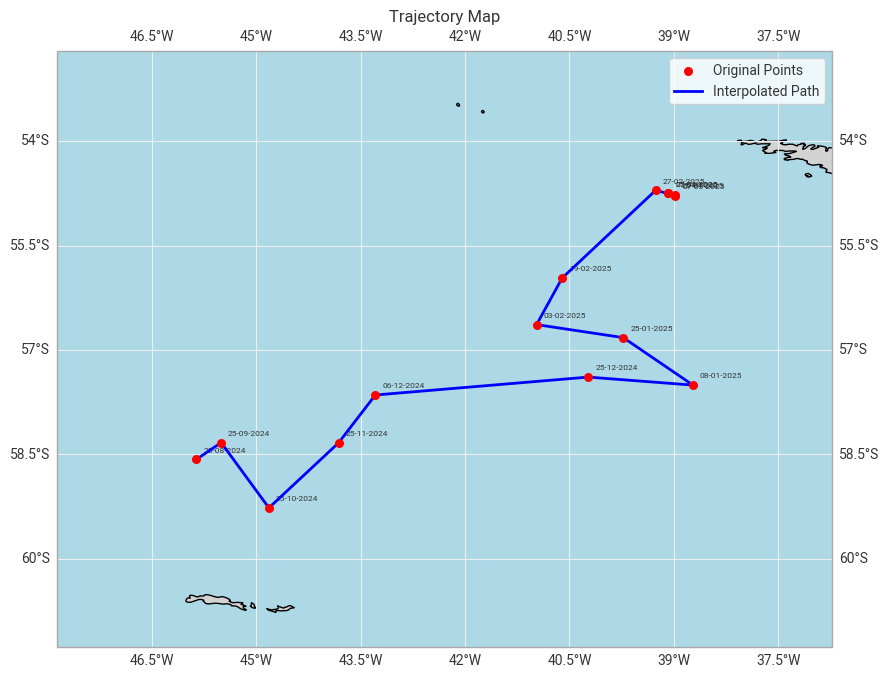

: 

In [38]:
# Create plot with PlateCarree projection
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True)

# Plot original trajectory points (red)
ax.scatter(
    trajectory_points['Lon'],
    trajectory_points['Lat'],
    color='red',
    s=30,
    label='Original Points',
    zorder=5,
)

# Annotate with time if needed
for _, row in trajectory_points.iterrows():
    ax.text(row['Lon'] + 0.1, row['Lat'] + 0.1, str(row['Date'].strftime("%d-%m-%Y")), fontsize=6)

# Plot interpolated trajectory (blue line)
ax.plot(
    df_interp['Lon'],
    df_interp['Lat'],
    color='blue',
    linewidth=2,
    label='Interpolated Path',
    zorder=4,
)

# Set extent (optional, zoom to trajectory)
buffer = 2
min_lat = min(trajectory_points['Lat'].min(), df_interp['Lat'].min()) - buffer
max_lat = max(trajectory_points['Lat'].max(), df_interp['Lat'].max()) + buffer
min_lon = min(trajectory_points['Lon'].min(), df_interp['Lon'].min()) - buffer
max_lon = max(trajectory_points['Lon'].max(), df_interp['Lon'].max()) + buffer
ax.set_extent([min_lon, max_lon, min_lat, max_lat])

# Add legend and title
ax.legend()
plt.title("Trajectory Map")

# Show the plot

plt.show()

We can see that the iceberg is slowly moving towards the island of South Georgia. While there are no humans on the island, the approaching iceberg can have severe impacts on the wildlife in the water and on land. 

<div class="alert alert-info" role="alert">

## 3. <a id='section2'></a>Access and processing of Sentnel-3 Data with EOCanvas
[Back to top](#totop)
    
</div>

In this section, we retrieve the **Sentinel-3 satellite image tiles** to see the iceberg. For more information on this dataset, refer to the [WEkEO data description](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3AOL_2_WFR___).

For simplicity, the process is shown for a single date in this example. The data for the rest of the dates is provided on an S3 bucket to make the execution of this notebook more convenient.

It is also possible to scale the process up to process the tiles for a larger timeframe. For information on how to process all the data, refer to Section **"Scaling Up"**.



### 3.1 Getting the Sentinel-3 OLCI Data 

Since the iceberg is large and moving, we define a spatial buffer around its estimated position to ensure complete coverage in the images. A latitude buffer of 1.5 degrees and a longitude buffer of 2.5 degrees is applied to compute a bounding box for each point along its trajectory.

In [7]:
# Define buffer size in degrees
buffer_lat = 1.5
buffer_lon = 2.5   

# Compute bounding box for each point
df_interp['W'] = df_interp['Lon'] - buffer_lon
df_interp['E'] = df_interp['Lon'] + buffer_lon
df_interp['S'] = df_interp['Lat'] - buffer_lat
df_interp['N'] = df_interp['Lat'] + buffer_lat

# Convert to list format
df_interp['bbox'] = df_interp.apply(lambda row: [row['W'], row['S'], row['E'], row['N']], axis=1)

# Display result
print(df_interp[['Lat', 'Lon', 'bbox']])


           Lat        Lon                                               bbox
0   -58.573400 -45.858900           [-48.3589, -60.0734, -43.3589, -57.0734]
1   -58.565584 -45.847432  [-48.347432258064515, -60.06558387096774, -43....
2   -58.557768 -45.835965  [-48.33596451612903, -60.057767741935486, -43....
3   -58.549952 -45.824497  [-48.32449677419355, -60.04995161290323, -43.3...
4   -58.542135 -45.813029  [-48.313029032258065, -60.042135483870965, -43...
..         ...        ...                                                ...
239 -54.765956 -39.002722  [-41.50272222222222, -56.26595555555556, -36.5...
240 -54.767167 -38.997467  [-41.49746666666667, -56.26716666666667, -36.4...
241 -54.768378 -38.992211  [-41.49221111111111, -56.26837777777778, -36.4...
242 -54.769589 -38.986956  [-41.486955555555554, -56.26958888888889, -36....
243 -54.770800 -38.981700           [-41.4817, -56.2708, -36.4817, -53.2708]

[244 rows x 3 columns]


Multiple Sentinel-3 tiles may be available for a given day, and not all will fully cover A23a. To ensure optimal coverage, we define a function that evaluates each available tile, comparing its footprint with the iceberg's bounding box. The function selects the tile with the highest overlap percentage, ensuring we use the most relevant image.

In [8]:
def get_best_coverage_index(r, bbox):
    """
    Finds the index of the image with the highest coverage of the bbox.

    Parameters:
    - results (list): List of image metadata, each containing 'geometry' with coordinates.
    - bbox (tuple): Bounding box as (min_x, min_y, max_x, max_y).

    Returns:
    - int: Index of the image with the best coverage.
    """
    coverages = []

    for img in r.results:
        footprint_coords = img['geometry']['coordinates'][0]
        footprint_polygon = Polygon(footprint_coords)
        
        # Create a box for the bbox
        bbox_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3])
        
        # Calculate the intersection of the bbox and the footprint
        intersection = footprint_polygon.intersection(bbox_polygon)
        
        # Calculate areas
        bbox_area = bbox_polygon.area
        intersection_area = intersection.area
        
        # Calculate coverage percentage
        coverage_percentage = (intersection_area / bbox_area) * 100
        coverages.append(coverage_percentage)
        
        print(f"The bbox is {coverage_percentage:.2f}% covered by the footprint.")

    # Get the index of the image with the highest coverage
    best_index = coverages.index(max(coverages))
    
    return best_index

Using the WEkEO API, we search for Sentinel-3 OLCI images based on the iceberg's bounding box and observation date. The query returns a list of available products, and we extract the download URL of the best-matching image. This URL serves as the input for further processing in EOCanvas, where we analyze the iceberg’s characteristics over time.

In [9]:
def wekeo_query(date, bbox):
    """
    Queries the WEkEO API for a specific date and location.
    
    Args:
        date (str): Date in the format 'YYYY-MM-DD'.
        bbox (list): bounding box
    
    Returns:
        str: The first download URL if products are found, or a "No matching products" message.
    """

    q = {
      "dataset_id": "EO:EUM:DAT:SENTINEL-3:OL_1_EFR___",
      "publication": "2021-12-20T09:47:09.915Z",
      "startdate": date+"T00:00:00.000Z",
      "enddate": date+"T23:59:59.999Z",
      "bbox": bbox,
      "type": "OL_1_EFR___",
      "timeliness": "NT",
      "itemsPerPage": 200,
      "startIndex": 0
    }

    c = Client()
    r = c.search(q)
    print (r)
    
    # Check if there are any results
    if len(r.results)==0:
        return None
    # Return the first download URL
    else: 
        idx = get_best_coverage_index(r, bbox)

    return r[idx].get_download_urls()[0]

The Image URL is our first input for the EOCanvas Processing. 

### 3.2 Setting Up the EOCanvas Process

**Goal of the EOCanvas Processing**:

The Sentinel-3 OLCI images cover a large area, but we are only interested in the region where Iceberg A23a is located. To facilitate analysis and visualization, we use EOCanvas to crop the satellite scene to the iceberg's bounding box and reproject the data to WGS84 (geographical coordinates). This ensures the extracted images align with standard mapping tools, making it easier to overlay and analyze the iceberg's movement.

To automate the cropping process, we define a function that updates an existing EOCanvas processing chain with the iceberg’s bounding box. The function takes the path to an EOCanvas processing file and modifies the Region of Interest (ROI) to match the iceberg’s location.

In [10]:
def update_datatailor_chain (file_path, bbox):
    [W,S,E,N] = bbox
    chain = Chain.from_file(file_path)
    chain.roi =  {'NSWE': [N, S, W, E], 'name': 'iceberg', 'id': 'iceberg'}
    return chain

After defining the bounding box and updating the EOCanvas processing chain, we need to execute the process to extract and reproject the relevant portion of the Sentinel-3 image. The function below takes the download URL of the satellite image, the processing chain, and an optional output directory to store the processed result.

In [11]:
def exec_dt_process(url, chain, download_dir='result'):
    print(f"Starting Data Tailor Process for product at {url}")
    inputs = Input(key="img1", url=url)
    process = DataTailorProcess(epct_chain=chain, epct_input=inputs)
    job = process.submit()
    process.run(job, download_dir=download_dir)
    return f"Finishing Data Tailor Process for product at {url}"

### 3.3 Executing the EOCanvas Process

As said before we only look at one date for simplicity of this notebook:

In [12]:
ds = df_interp.iloc[0]
date = str(ds['Date'].date())
bbox = ds['bbox']

print ("Example Date:" , date)
print ("Bounding Box: ", bbox)

Example Date: 2024-08-25
Bounding Box:  [-48.3589, -60.0734, -43.3589, -57.0734]


We only defined the functions before. Now we stitch all together and execute the process.

In [20]:
url = wekeo_query(date, bbox)
chain = update_datatailor_chain("input_graphs/iceberg_chain.yaml", bbox)
download_dir = "result"
exec_dt_process(url, chain, download_dir)

SearchResults[items=2,volume=984MB]
The bbox is 100.00% covered by the footprint.
The bbox is 54.61% covered by the footprint.
Starting Data Tailor Process for product at https://gateway.prod.wekeo2.eu/hda-broker/api/v1/dataaccess/download/68679e12e66d67b2cde9f56e
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: accepted at 2025-07-04T11:25:40.383285
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:25:50.808035
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:26:02.170241
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:26:14.534969
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:26:28.083272
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:26:42.973877
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:26:59.686235
Job: aa218b6a-e3ef-5d9c-baed-e7bc5008e6b3 - Status: running at 2025-07-04T11:27:17.855637
Job: aa218b6a-

'Finishing Data Tailor Process for product at https://gateway.prod.wekeo2.eu/hda-broker/api/v1/dataaccess/download/68679e12e66d67b2cde9f56e'

<div class="alert alert-info" role="alert">

## 4. <a id='section3'></a>Post-processing
[Back to top](#totop)
    
</div>

The Data Tailor process successfully extracts a smaller, reprojected image from the large Sentinel-3 scene, focusing only on the region where Iceberg A23a is located. However, before we can effectively visualize the image, additional post-processing steps are required to ensure consistency across time and space.

**Key Post-Processing Steps:**
* Adding a Time Dimension: Integrating temporal information allows us to track the iceberg's movement over time.
* Regridding the Data: Aligning the extracted data to a common spatial grid ensures compatibility with other datasets and facilitates analysis.


These steps refine the data, making it ready for visualization and further interpretation.

In [21]:
# Examine the result file

file = glob.glob("result/OLL1EFR_20240825T115856Z*.nc")[0]
ds = xr.open_dataset(file)
ds

<xarray.Dataset> Size: 20MB
Dimensions:        (lat: 1000, lon: 1667)
Coordinates:
  * lat            (lat) float64 8kB -60.07 -60.07 -60.07 ... -57.08 -57.07
  * lon            (lon) float64 13kB -48.36 -48.35 -48.35 ... -43.36 -43.36
Data variables:
    crs            |S1 1B ...
    oa03_radiance  (lat, lon) float32 7MB ...
    oa06_radiance  (lat, lon) float32 7MB ...
    oa08_radiance  (lat, lon) float32 7MB ...
Attributes: (12/59)
    Conventions:               CF-1.5
    absolute_orbit_number:     44385
    ac_subsampling_factor:     64
    al_subsampling_factor:     1
    contact:                   ops@eumetsat.int
    creation_time:             2024-08-26T23:09:39Z
    ...                        ...
    EPCT_roi:                  iceberg
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_name:        DataTailor
    EPCT_software_version:     3.4.0
    EPCT_stretch_method:       null

In [22]:
# Adding the time dimension

timestamp = pd.to_datetime(ds.attrs['start_time'])
ds = ds.expand_dims(time=[timestamp])
ds['time'] = pd.to_datetime(ds.time, unit='ns')
ds

<xarray.Dataset> Size: 20MB
Dimensions:        (time: 1, lat: 1000, lon: 1667)
Coordinates:
  * time           (time) datetime64[ns] 8B 2024-08-25T11:57:55.401402
  * lat            (lat) float64 8kB -60.07 -60.07 -60.07 ... -57.08 -57.07
  * lon            (lon) float64 13kB -48.36 -48.35 -48.35 ... -43.36 -43.36
Data variables:
    crs            (time) |S1 1B b''
    oa03_radiance  (time, lat, lon) float32 7MB 72.67 72.67 ... 37.82 37.82
    oa06_radiance  (time, lat, lon) float32 7MB 59.62 59.62 ... 22.19 22.19
    oa08_radiance  (time, lat, lon) float32 7MB 54.21 54.21 ... 17.05 17.05
Attributes: (12/59)
    Conventions:               CF-1.5
    absolute_orbit_number:     44385
    ac_subsampling_factor:     64
    al_subsampling_factor:     1
    contact:                   ops@eumetsat.int
    creation_time:             2024-08-26T23:09:39Z
    ...                        ...
    EPCT_roi:                  iceberg
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_name:        DataTailor
    EPCT_software_version:     3.4.0
    EPCT_stretch_method:       null

In [23]:
#Bring to a common grid

min_lat, max_lat = -61, -51
min_lon, max_lon = -50, -37
resolution = 0.003

new_lats = np.arange(min_lat, max_lat + resolution, resolution)
new_lons = np.arange(min_lon, max_lon + resolution, resolution)

# Step 1: Define the new grid (lat/lon)
new_lon_grid, new_lat_grid = np.meshgrid(new_lons, new_lats)

In [24]:
ds_regrid = ds.interp(lon=new_lons, lat=new_lats, method="linear")

Now we can visualize the result of our post-processing. 

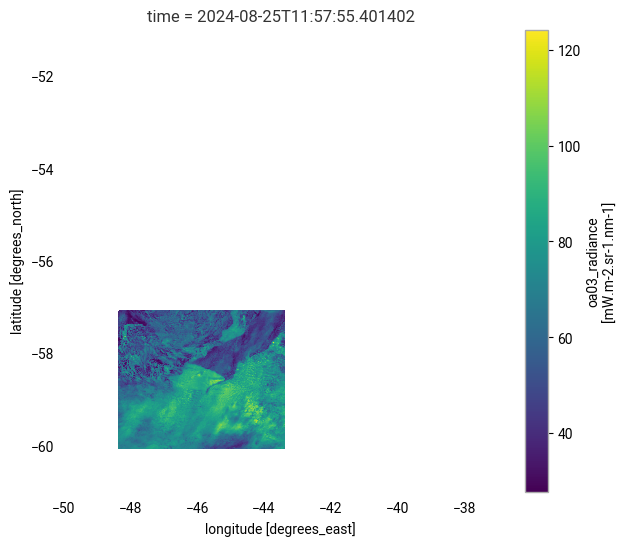

In [25]:
ds_regrid.oa03_radiance.isel(time=0).plot()

<div class="alert alert-info" role="alert">

## 5. <a id='section4'></a>Scaling Up: Access, Processing and Post-Processing of a 6 month time series
[Back to top](#totop)
    
</div>


For scaling up the processing capablities, we add a few functionalities on top of the proviously defined functions:

* **Logging the status of the processing**: Whe dealing with a long time series, we want to keep track of the progress and if the processes were successful or failing. The status file will capture the status of the processing. With the help of this we can also make sure that we skip files that have been processed already when we re-start out processing.  

* **Handling the Quotas during processing**: It is likely that we run into our processing limits for the eocanvas during the processing (10 requests / hour). The function `safe_exec_dt_process` ensures that the processing is paused and restarted after 5 minutes of time in case we hit the quota. 

* **Conversion and Uploading to zarr**: the function `convert_and_upload_to_zarr` takes over the post-processing steps we did in section 4. Additionally, we upload the result to a S3 bucket. To do this, you need to set credentials to your own S3 bucket. If you don't have one but you have a project which requires these resources, check out the **<a href="https://wekeo.copernicus.eu/news/wekeo-launches-the-copernicus-innovation-lab-" target="_blank">Copernicus Innovation Lab</a>**

In [19]:
# Function to load the status from the file
def load_status(file_path):
    try:
        with open(file_path, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        return {}

# Function to save the status to the file
def save_status(file_path, status):
    with open(file_path, 'w') as f:
        json.dump(status, f, indent=4)

In [20]:
# Thread-safe wrapper for exec_snap_process
def safe_exec_dt_process(date, url, chain, download_dir):
    global process_status
    while True:  # Outer loop to handle restarting on error
        try:
            process_status[date] = "eocanvas process submitted"
            save_status(status_file, process_status)

            # Attempt to execute the process
            exec_dt_process(url, chain, download_dir)

            process_status[date] = "eocanvas process finished"
            save_status(status_file, process_status)

            print(f"Process for {date} completed.")
            status = "success"
            break  # Exit the while loop if successful

        except QuotaExceededError:  # Replace with the actual exception name
            print(f"Quota exceeded for {date}. Waiting 5 minutes to retry...")
            time.sleep(300)  # Wait 5 minutes (300 seconds) before retrying
            url = None
            while url is None:
                url = wekeo_query(date, bbox)
        except Exception as e:  # Handle all other exceptions
            process_status[date] = "eocanvas process failed"
            save_status(status_file, process_status)
            print(f"An error occurred for {date}: {e}")
            status = "fail"
            break  # Exit the while loop if a non-retryable error occurs
    return status

In [21]:
def convert_and_upload_to_zarr(bucket_name, prefix, storage_options, directory="result"):
    """
    Searches for a NetCDF file in the specified directory, converts it to Zarr, 
    uploads it to CloudFerro S3, and removes the local file.

    Parameters:
    - bucket_name (str): CloudFerro S3 bucket name.
    - prefix (str): Folder path inside the bucket.
    - storage_options (dict): S3 authentication options.
    - directory (str): Directory to search for NetCDF files (default: "result").
    """

    # Search for the first NetCDF file in the directory
    file_list = glob.glob(os.path.join(directory, "OLL1EFR_*.nc"))
    if not file_list:
        print("No NetCDF files found in the directory.")
        process_status[date] = "no result file in directory"
        save_status(status_file, process_status)
        return
    
    file = file_list[0]  # Process the first found file
    print(f"Processing file: {file}")

    # Open dataset
    ds = xr.open_dataset(file)
    timestamp = pd.to_datetime(ds.attrs['start_time'])
    ds = ds.expand_dims(time=[timestamp])
    ds['time'] = pd.to_datetime(ds.time, unit='ns')

    ds_regrid = ds.interp(lon=new_lons, lat=new_lats, method="linear")
    
    # Define the Zarr store path
    zarr_path = f"s3://{bucket_name}/{prefix}{os.path.basename(file).replace('.nc', '.zarr')}"

    # Save dataset as Zarr in CloudFerro S3
    ds_regrid.to_zarr(store=zarr_path, mode="w", storage_options=storage_options)

    print(f"Stored {file} as {zarr_path}")

    # Remove the local file
    os.remove(file)
    print(f"Deleted local file: {file}")

In [16]:
# Configure your object store (e.g., AWS S3)
storage_options = {
    "key": "****",
    "secret": "****",
    "client_kwargs": {
        "endpoint_url": "https://s3.waw3-2.cloudferro.com",
        "region_name": "waw3-2",
    }
}

# Set bucket and folder path
bucket_name = "wekeo"
prefix = "a23a/"  # Change to your desired folder

The next cell is commented out so that the bulk processing is not triggered by accident. If you want to bulk process files, simply un-comment the cell below and you are good to go. 

In [17]:
# process_status = {}
# process_times = []  # List to track process start times
# status_file = "process_status.json"  # Path to status file

# for i in range(len(df_interp)):
#     ds = df_interp.iloc[i]
#     date = str(ds['Date'].date())
#     bbox = ds['bbox']

    
#     process_status = load_status(status_file)

#     # Check if date has been processed already
#     current_status = process_status.get(date, "not yet started")
#     if current_status in ["eocanvas process finished"]:
#         convert_and_upload_to_zarr(bucket_name, prefix, storage_options)
#         continue
#     elif current_status in ["process completed"]:
#         print(f"Skipping process {date} (current status: {current_status}).")
#         continue
        
#     # Update status to "in progress"
#     process_status[date] = "in progress"
#     save_status(status_file, process_status)

    
#     url = wekeo_query(date, bbox)


#     if url is None:
#         process_status[date] = "no data available"
#         save_status(status_file, process_status)
#         continue

#     chain = update_datatailor_chain("input_graphs/iceberg_chain.yaml", bbox)
#     download_dir = "result"
#     exec_dt_process(url, chain, download_dir)
#     status="success"
#     #status = safe_exec_dt_process(date, url, chain, download_dir)
#     if status == "fail":
#         continue
        
#     convert_and_upload_to_zarr(bucket_name, prefix, storage_options)

#     process_status[date] = "process completed"
#     save_status(status_file, process_status)

Skipping process 2024-08-25 (current status: process completed).
Skipping process 2024-08-26 (current status: process completed).
Skipping process 2024-08-27 (current status: process completed).
Skipping process 2024-08-28 (current status: process completed).
Skipping process 2024-08-29 (current status: process completed).
Skipping process 2024-08-30 (current status: process completed).
Skipping process 2024-08-31 (current status: process completed).
Skipping process 2024-09-01 (current status: process completed).
Skipping process 2024-09-02 (current status: process completed).
Skipping process 2024-09-03 (current status: process completed).
Skipping process 2024-09-04 (current status: process completed).
Skipping process 2024-09-05 (current status: process completed).
Skipping process 2024-09-06 (current status: process completed).
Skipping process 2024-09-07 (current status: process completed).
Skipping process 2024-09-08 (current status: process completed).
Skipping process 2024-09-



<div class="alert alert-info" role="alert">

## 6. <a id='section5'></a>Visualizing
[Back to top](#totop)
    
</div>


For your convenience, the full time range from end-August to mid-March was processed and made available on an S3 bucket. Therefore, you can continue with this notebook and make nice visualizations without the need to process all the data again. 

You can see all available data by reading the S3 directory:

In [26]:
def list_zarr_files(bucket_name, prefix):
    """
    Lists all .zarr files in a specific directory of an S3 bucket.

    Parameters:
    - bucket_name (str): CloudFerro S3 bucket name.
    - prefix (str): Folder path inside the bucket (e.g., "zarr-datasets/").

    Returns:
    - list: A list of .zarr file paths.
    """

    # Initialize filesystem for the CloudFerro S3 bucket
    fs = fsspec.filesystem("s3", 
        endpoint_url="https://s3.waw3-2.cloudferro.com",
        anon=True  # Set to False if authentication is required
    )

    # List files in the given prefix
    file_list = fs.ls(f"{bucket_name}/{prefix}")

    # Filter only .zarr files
    zarr_files = [f"s3://{file}" for file in file_list if file.endswith(".zarr")]

    return zarr_files

In [29]:
bucket_name = "wekeo"
prefix = "a23a/"  # Adjust to your folder

zarr_files = list_zarr_files(bucket_name, prefix)
print("\n".join(zarr_files[0:10]))  # Print list of Zarr files

s3://wekeo/a23a/OLL1EFR_20240825T115856Z_20240825T115958Z_epct_3ccf4f11_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240826T113306Z_20240826T113359Z_epct_d54db4dc_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240827T120844Z_20240827T120945Z_epct_a77526d0_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240828T114253Z_20240828T114356Z_epct_b33b8f50_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240829T115513Z_20240829T115615Z_epct_cb3adc3a_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240830T112923Z_20240830T113027Z_epct_27eec48a_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240831T120502Z_20240831T120603Z_epct_a000554d_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240901T113911Z_20240901T114014Z_epct_e3ce5f4e_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240902T115129Z_20240902T115231Z_epct_84ef4341_FAPRC.zarr
s3://wekeo/a23a/OLL1EFR_20240903T112541Z_20240903T112645Z_epct_a4191752_FAPRC.zarr


We will now read in the data from the S3 bucket and create a nice video that shows the trajectory if the iceberg. 

In [30]:
ds = xr.open_mfdataset(
    zarr_files[0:-1],
    backend_kwargs={
        "storage_options": {
            "endpoint_url": "https://s3.waw3-2.cloudferro.com",
            "anon": True
        },
    },
    engine="zarr",
)

In [31]:
ds

<xarray.Dataset> Size: 68GB
Dimensions:        (time: 195, lat: 3335, lon: 4335)
Coordinates:
  * lat            (lat) float64 27kB -61.0 -61.0 -60.99 ... -51.0 -51.0 -51.0
  * lon            (lon) float64 35kB -50.0 -50.0 -49.99 ... -37.0 -37.0 -37.0
  * time           (time) datetime64[ns] 2kB 2024-08-25T11:57:55.401402 ... 2...
Data variables:
    crs            (time) |S1 195B dask.array<chunksize=(1,), meta=np.ndarray>
    oa03_radiance  (time, lat, lon) float64 23GB dask.array<chunksize=(1, 209, 542), meta=np.ndarray>
    oa06_radiance  (time, lat, lon) float64 23GB dask.array<chunksize=(1, 209, 542), meta=np.ndarray>
    oa08_radiance  (time, lat, lon) float64 23GB dask.array<chunksize=(1, 209, 542), meta=np.ndarray>
Attributes: (12/59)
    Conventions:               CF-1.5
    EPCT_aggregation:          orbit
    EPCT_chain name:           Custom
    EPCT_creation_time:        2025-01-30T18:39:10.291762Z
    EPCT_filter:               custom
    EPCT_format:               netcdf4
    ...                        ...
    product_name:              S3A_OL_1_EFR____20240825T115755_20240825T11594...
    references:                S3IPF PDS 004.1 - i2r7 - Product Data Format S...
    resolution:                [ 270 294 ]
    source:                    IPF-OL-1-EO 06.19
    start_time:                2024-08-25T11:57:55.401402Z
    stop_time:                 2024-08-25T11:59:45.272598Z

In [32]:
print("Starting Date: ", ds.time[0].values)
print("Ending Date: ", ds.time[-1].values)

Starting Date:  2024-08-25T11:57:55.401402000
Ending Date:  2025-03-07T10:49:16.856571000


You have all the images from 25th August to 6th March in your xarray. 

Next, we will make a visualization of the iceberg for one date:

c:\Users\erdmann\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\array\reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
c:\Users\erdmann\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
c:\Users\erdmann\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


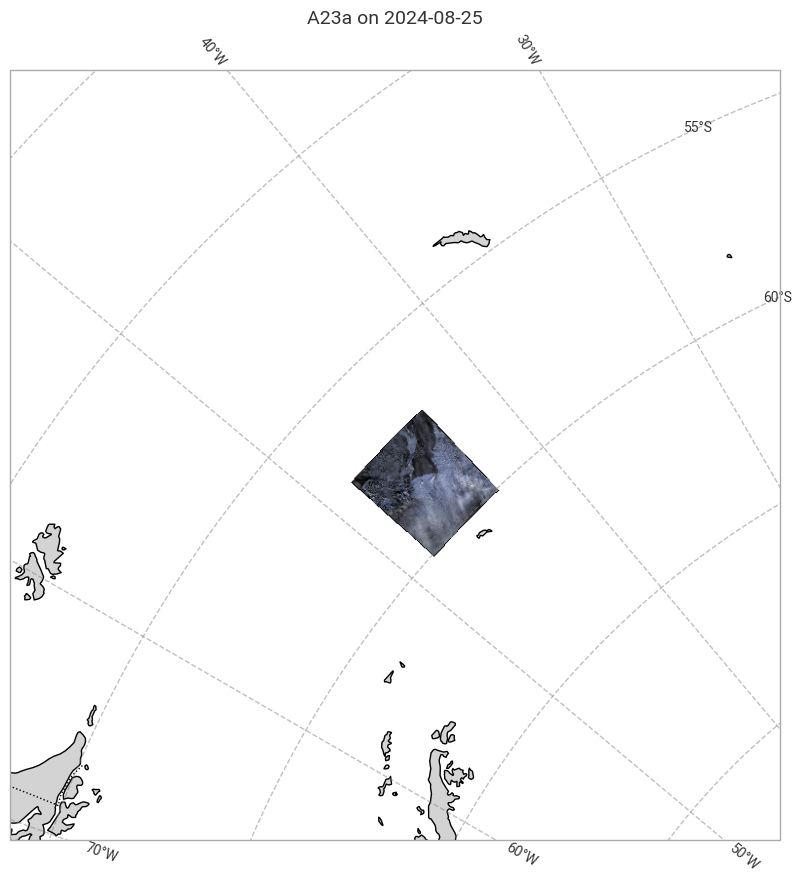

In [33]:
# Extract & Normalize Bands
blue = ds['oa03_radiance'].isel(time=0)
green = ds['oa06_radiance'].isel(time=0)
red = ds['oa08_radiance'].isel(time=0)

def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

# Stack into RGB (H, W, 3)
rgb_image = np.dstack([red_norm, green_norm, blue_norm])
# Mask NaN values in the image (make NaNs transparent)
rgb_image = np.ma.masked_invalid(rgb_image)

# Get lat/lon extents
lat_min, lat_max = ds.lat.min()-5, ds.lat.max()
lon_min, lon_max = ds.lon.min()-10, ds.lon.max()+5

lat_min_img, lat_max_img = ds.lat.min(), ds.lat.max()
lon_min_img, lon_max_img = ds.lon.min(), ds.lon.max()

# Flip image if needed (depends on dataset orientation)
rgb_image = np.flipud(rgb_image)

# **Step 1: Create Polar Projection**
proj = ccrs.SouthPolarStereo()

# **Step 2: Create the plot**
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': proj})

# **Step 3: Add map features**
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--', alpha=0.5)

# **Step 4: Plot the RGB image with transparency for NaN values**
ax.imshow(
    rgb_image,
    origin="upper",
    extent=[lon_min_img, lon_max_img, lat_min_img, lat_max_img],
    transform=ccrs.PlateCarree(),
    alpha=1.0  # Use alpha transparency to make NaNs invisible
)

# **Step 5: Final Touches**
ax.set_title(f"A23a on {str(ds.isel(time=0).time.dt.date.item())}", fontsize=14)
plt.show()


If this looks good to you, the next step is to extend the visualization to make a nice video that shows the movement of the iceberg over the complete time period. 

**Warning: This might take a couple of minutes as it is computationally expensive.**

In [23]:
frames = []
for i in range(len(ds.time)):
    # Extract & Normalize Bands
    blue = ds['oa03_radiance'].isel(time=i-1)
    green = ds['oa06_radiance'].isel(time=i-1)
    red = ds['oa08_radiance'].isel(time=i-1)
    
    def normalize_band(band):
        return (band - band.min()) / (band.max() - band.min())
    
    red_norm = normalize_band(red)
    green_norm = normalize_band(green)
    blue_norm = normalize_band(blue)
    
    # Stack into RGB (H, W, 3)
    rgb_image = np.dstack([red_norm, green_norm, blue_norm])
    rgb_image = np.ma.masked_invalid(rgb_image)
    
    # Get lat/lon extents
    lat_min, lat_max = ds.lat.min()-2, ds.lat.max()
    lon_min, lon_max = ds.lon.min()-10, ds.lon.max()+5
    
    lat_min_img, lat_max_img = ds.lat.min(), ds.lat.max()
    lon_min_img, lon_max_img = ds.lon.min(), ds.lon.max()
    
    # Flip image if needed (depends on dataset orientation)
    rgb_image = np.flipud(rgb_image)
    
    # **Step 1: Create Polar Projection**
    proj = ccrs.SouthPolarStereo()
    
    # **Step 2: Create the plot**
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': proj})
    
    # **Step 3: Add map features**
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', linestyle='--', alpha=0.5)
    
    # **Step 4: Plot the RGB image**
    ax.imshow(
        rgb_image,
        origin="upper",
        extent=[lon_min_img, lon_max_img, lat_min_img, lat_max_img],
        transform=ccrs.PlateCarree()
    )
    
    # **Step 5: Final Touches**
    ax.set_title(f"A23a on {str(ds.isel(time=i-1).time.dt.date.item())}", fontsize=14)
    dir_path = 'frames'
    frame_path = f'{dir_path}/frame_{str(ds.isel(time=i-1).time.dt.date.item())}.png'

    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        
    plt.savefig(frame_path)
    plt.close()

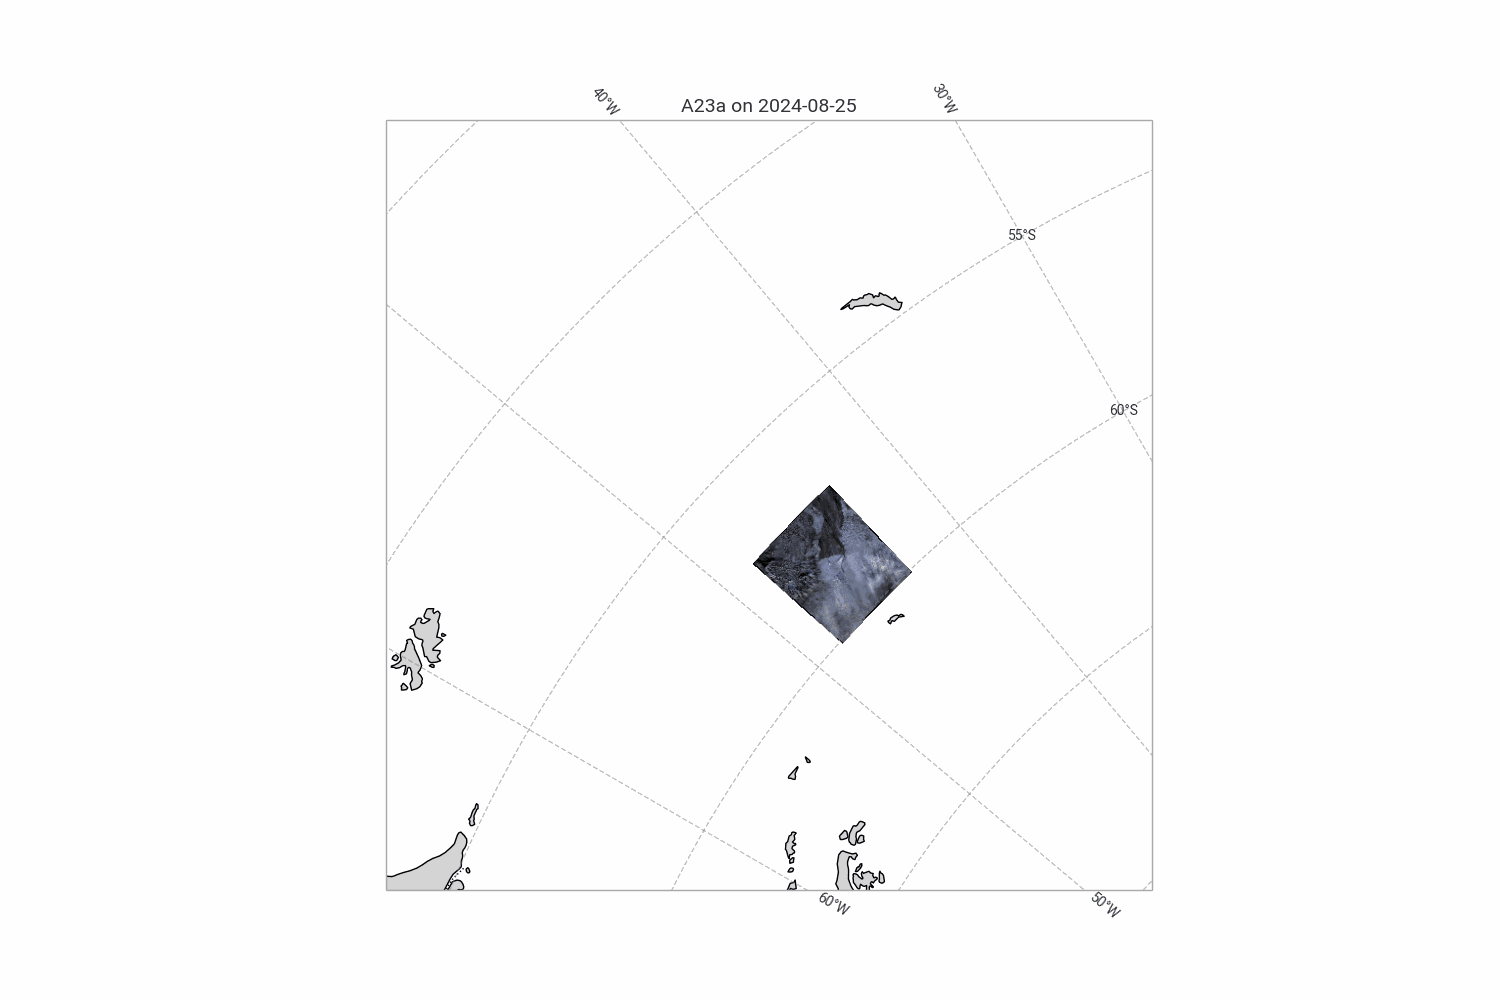

In [34]:
import imageio.v2 as imageio
from PIL import Image

folder_path = "frames"

images = sorted([img for img in os.listdir(folder_path) if img.endswith(".png")])


first_image = Image.open(os.path.join(folder_path, images[0]))
target_size = first_image.size  # (Breite, Höhe)


frames = []
for img in images:
    image = Image.open(os.path.join(folder_path, img))
    image = image.resize(target_size)  # Größe anpassen
    frames.append(image)

# save as GIF
frames[0].save("animation.gif", save_all=True, append_images=frames[1:], duration=250, loop=0)

from IPython.display import Image
Image(filename="animation.gif")